## Gossipcop

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk import  pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


from textblob import TextBlob

import matplotlib.pyplot as plt 
from matplotlib import rcParams

import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression

from collections import Counter

import scipy.sparse  
from scipy.sparse import hstack, csr_matrix


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error



In [2]:
base_dir= '.' 
dataset= 'GossioCop'
data_dir= os.path.join(base_dir, dataset)

# Cleanning GossipCop

In [3]:
g1= pd.read_csv(os.path.join(data_dir, 'gossipcop_fake.csv'))
g2= pd.read_csv(os.path.join(data_dir, 'gossipcop_real.csv'))

In [4]:
g1['label']= 0 # 0 for fake news
g2['label']= 1 # 1 for real news

In [5]:
gossipcop= pd.concat([g1, g2], axis= 0)
gossipcop.head(2)

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0


In [6]:
gossipcop.to_csv(os.path.join(data_dir, 'gossipcop.csv') ,index= False)

In [7]:
gossipcop= pd.read_csv(os.path.join(data_dir, 'gossipcop.csv'))

In [8]:
gossipcop

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0
...,...,...,...,...,...
22135,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1
22136,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1
22137,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1
22138,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1


In [9]:
# selecting 20000 row 
gossipcop = gossipcop.sample(n=20000, random_state=10)
gossipcop.shape

(20000, 5)

In [10]:
#task2 : remove marks and stopwords
# defining a funtion to make the lowercase and remove links, square brackets, punctuation and words contianing numbers 
def review_cleaning(text):
    '''
    make the lowercase and remove links, square brackets, punctuation and words contianing numbers.  
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(',()''', '', text)

    return text

In [11]:
# Tokenization and stopword
stop = stopwords.words('english')

gossipcop['news'] = gossipcop['title'].apply(lambda text: review_cleaning(text))

gossipcop['news']= gossipcop['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [12]:
def source(text):
    txt= text.split('/')
    return txt[0]

In [13]:
def remove_http(text):
    text= str(text)
    txt= text
    if 'http://' in text:
        txt=  text.replace('http://', '')
    elif 'https://' in text:
        txt=  text.replace('https://', '')
    return txt

In [14]:
try:
    gossipcop['news_url']= gossipcop['news_url'].apply(lambda text: remove_http(text))
except Exception as er:
    print(er)

In [15]:
try:
    gossipcop['source']= gossipcop['news_url'].apply(lambda text: source(str(text)))
except Exception as er:
    print(er)

In [16]:
# fill NaNs with zeros
gossipcop = gossipcop.fillna(gossipcop.mean(numeric_only=True))


In [17]:
# drop nan rows in news 
gossipcop.dropna(subset=['news'], inplace=True)

In [18]:
gossipcop.shape

(20000, 7)

In [19]:
# removing id, news_url, tweet_ids columns
gossipcop= gossipcop[['news', 'source', 'label']]

###  task3 visualization


In [20]:
def count_news_type(dataset, column):
    #Plotting the frequency plot
    highest= gossipcop[column].value_counts().head(10)

    ax = sns.barplot(y= highest.index, x= highest.values,
                        palette="dark", orient="h")

    #Setting labels and font size
    ax.set(xlabel='Type of news', ylabel='Source of news',title='Count of news')
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)

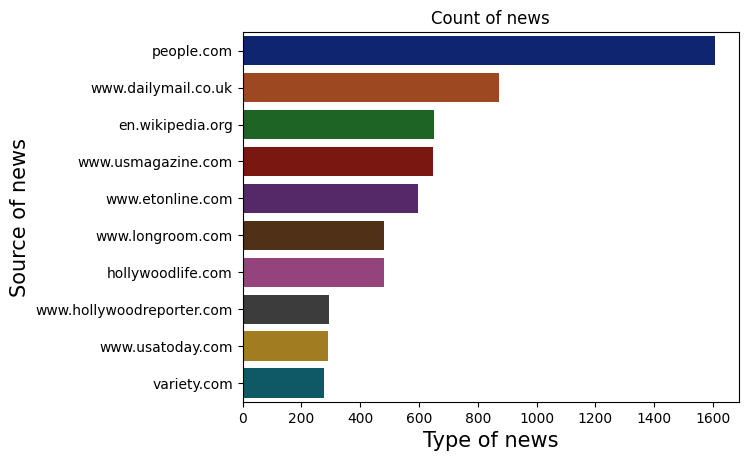

In [21]:
count_news_type(gossipcop, 'source')

In [22]:
gossipcop['source'].value_counts().head(10)


people.com                   1607
www.dailymail.co.uk           872
en.wikipedia.org              652
www.usmagazine.com            647
www.etonline.com              598
www.longroom.com              482
hollywoodlife.com             480
www.hollywoodreporter.com     295
www.usatoday.com              292
variety.com                   276
Name: source, dtype: int64

In [23]:
len(gossipcop['source'].unique())

1970

## Count of fake news and true news


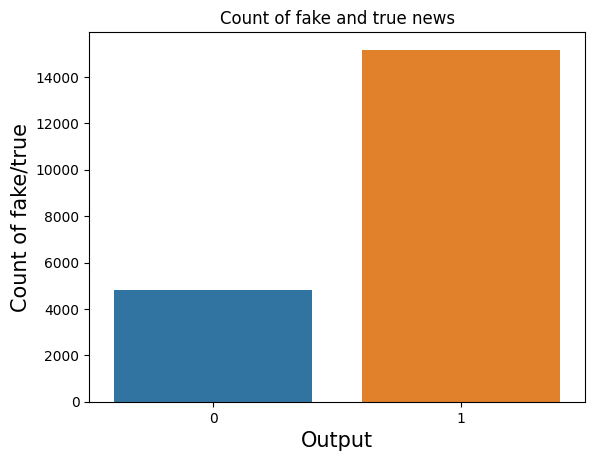

In [24]:
## Count of fake news and true news
ax=sns.countplot(x="label", data=gossipcop)
#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

# Stopwords

In [25]:
# factorize source column and convert to number
gossipcop["source"] = pd.factorize(gossipcop["source"])[0]

In [26]:
gossipcop.head(3)

,news,source,label
12850,donald glover,0,1
3773,everything know kevin harts alleged extortion ...,1,0
20364,oscars memorable academy awards acceptance spe...,2,1


### Feature Extraction

In [27]:
def feature_extraction(News, column):
    #Extracting the features from the news
    News['polarity'] = News[column].map(lambda text: TextBlob(str(text)).sentiment.polarity)
    News['review_len'] = News[column].astype(str).apply(len)
    News['word_count'] = News[column].apply(lambda x: len(str(x).split()))

    #Plotting the distribution of the extracted feature
    plt.figure(figsize = (20, 5))
    plt.style.use('seaborn-white')
    plt.subplot(131)
    sns.distplot(News['polarity'])
    fig = plt.gcf()
    plt.subplot(132)
    sns.distplot(News['review_len'])
    fig = plt.gcf()
    plt.subplot(133)
    sns.distplot(News['word_count'])
    fig = plt.gcf();

C:\Users\mahmoud\AppData\Local\Temp\ipykernel_11408\1703162373.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\mahmoud\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

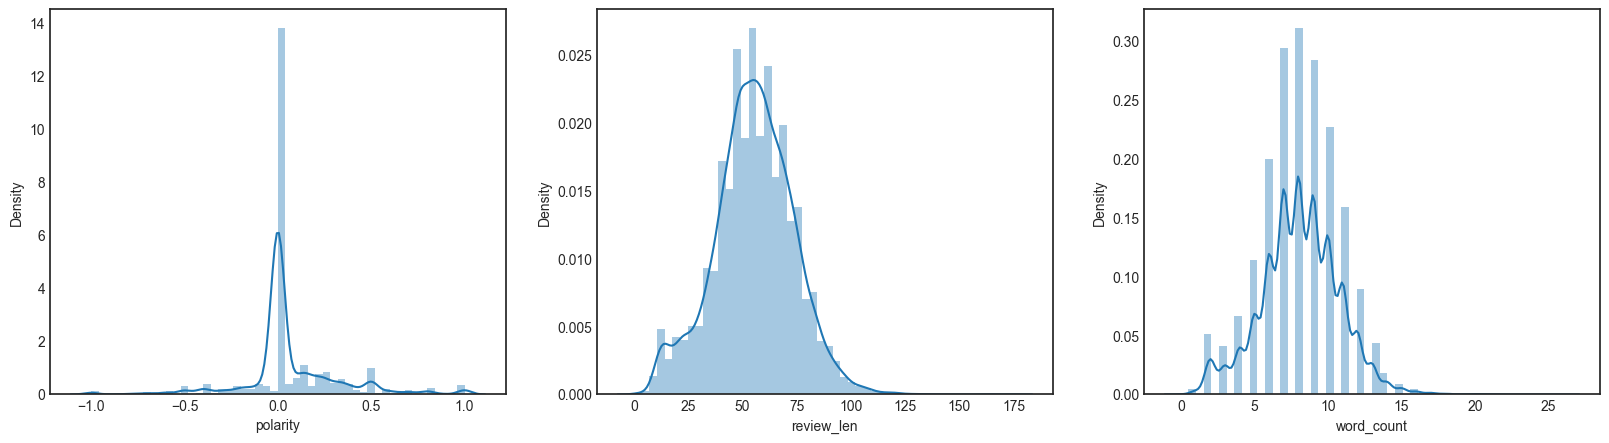

In [28]:
%matplotlib inline
feature_extraction(gossipcop, 'news')

In [29]:
# fill NaNs with zeros
gossipcop = gossipcop.fillna(gossipcop.mean(numeric_only=True))


In [30]:
non_numeric_columns = gossipcop.select_dtypes(exclude=['number']).columns
non_numeric_columns

Index(['news'], dtype='object')

In [31]:
# drop nan rows in news 
gossipcop.dropna(subset=['news'], inplace=True)

In [32]:
gossipcop.to_csv(os.path.join(data_dir, 'gossipcop_stm_fe.csv') ,index= False)

In [33]:
gossipcop= pd.read_csv(os.path.join(data_dir, 'gossipcop_stm_fe.csv'))

In [34]:
gossipcop.dropna(subset=['news'], inplace=True)

In [35]:
gossipcop.shape

(19997, 6)

## Feature selection
#### Filter method

In [36]:
features= gossipcop.drop(['news', 'label'], axis= 1)
features.head(2)

,source,polarity,review_len,word_count
0,0,0.0,13,2
1,1,-0.1,68,9


In [37]:
# mutual_info_classif for feature selection
k_best_mi = SelectKBest(mutual_info_classif, k=2)  # Select top 6 features
features_selected_mi = k_best_mi.fit_transform(features, gossipcop['label'])
# features_selected_mi
selected_feature_indices = k_best_mi.get_support(indices=True)
selected_column_mi = set(features.columns[selected_feature_indices])
selected_column_mi

{'polarity', 'source'}

In [38]:
# f_classif for feature selection
k_best_f = SelectKBest(f_classif, k=2)  # Select top 6 features
X_selected_f = k_best_f.fit_transform(features, gossipcop['label'])
selected_feature_indices = k_best_mi.get_support(indices=True)
selected_column_f_class = set(features.columns[selected_feature_indices])
selected_column_f_class

{'polarity', 'source'}

In [39]:
# LASSO (L1 regularization) for feature selection
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')
lasso_model.fit(features, gossipcop['label'])
# Get the absolute values of the coefficients
abs_coef = abs(lasso_model.coef_[0])

# Get the indices of the three largest coefficients (features with highest absolute coefficient values)
top_3_indices = abs_coef.argsort()[-2:][::-1]

# Get the names of the three best features
selected_features_lasso = features.columns[top_3_indices]

# Create the final feature matrix with the three selected features
features_selected_lasso = set(features[selected_features_lasso])

features_selected_lasso

{'polarity', 'word_count'}

In [40]:
# 
# Calculate the correlation matrix
features= gossipcop.drop(['news'], axis= 1)
correlation_matrix = features.corr()

# Select features with high correlation to the target variable (absolute correlation values)
threshold = 0.2  
selected_features_corr = correlation_matrix[abs(correlation_matrix['label']) > threshold].index

# Create the final feature matrix
features_selected_corr = set(features[selected_features_corr])
features_selected_corr

{'label'}

#### Wrapper methods
##### using lasso for all features including news column

In [41]:
# Creating bag of words
def bow(corpus):
    vectorizer = CountVectorizer()
    news_features = vectorizer.fit_transform(corpus).toarray()
    return news_features

In [42]:
gossipcop

,news,source,label,polarity,review_len,word_count
0,donald glover,0,1,0.00,13,2
1,everything know kevin harts alleged extortion ...,1,0,-0.10,68,9
2,oscars memorable academy awards acceptance spe...,2,1,0.50,51,6
3,ariana grande arrives england manchester benef...,3,1,0.00,56,7
4,prince royce goes shirtless dancing underwear ...,4,1,0.25,61,9
...,...,...,...,...,...,...
19995,would thought kylie would successful kardashian,807,0,0.75,47,6
19996,beyonce shows flawless figure serena williams ...,34,1,1.00,53,7
19997,met gala katy perry flew kim kardashians nails la,1,1,0.00,49,9
19998,caitlyn jenner caught dinner date ex girlfrien...,185,0,0.00,60,9


In [43]:
news_bow= bow(gossipcop['news'])
print('Shape of bag of words on news: ', news_bow)
print('The number of new columns is added to dataset is: ', news_bow.shape[1])


Shape of bag of words on news:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
The number of new columns is added to dataset is:  17042


In [44]:
def cancat_two_part(dataset, vertorized_feature):
    # Step 1: Scale the numerical features using StandardScaler and convert to a sparse matrix
    other_features = dataset.drop(columns=['news', 'label'])
    scaler = StandardScaler()
    scaled_other_features = scaler.fit_transform(other_features)
    sparse_scaled_other_features = csr_matrix(scaled_other_features)

    # Step 2: Concatenate the sparse matrices for 'news' and numerical features
    all_features = hstack([vertorized_feature, sparse_scaled_other_features])

    return all_features

In [45]:
gossipcop_bow= cancat_two_part(gossipcop, news_bow)
gossipcop_bow

<19997x17046 sparse matrix of type '<class 'numpy.float64'>'
	with 239673 stored elements in COOrdinate format>

In [46]:
# Information Gain feature selection method

In [47]:
def informatio_gain(dataset, label):

    # Calculate Information Gain using mutual information
    information_gains_all = mutual_info_classif(dataset, label)  # Exclude non-numeric columns
    # Print Information Gains for each feature
    columns = [ 'source', 'polarity', 'review_len', 'word_count'] 
    other_features= len(columns)
    selected_features= []
    information_gains= information_gains_all[-other_features:]
    for i, gain in enumerate(information_gains):
        print(f"Feature {columns[i]}: Information Gain = {gain:.6f}")
        selected_features.append(columns[i])
    return selected_features

In [48]:
selected_features_ig= informatio_gain(gossipcop_bow, gossipcop['label'])

Feature source: Information Gain = 0.216845
Feature polarity: Information Gain = 0.024568
Feature review_len: Information Gain = 0.006337
Feature word_count: Information Gain = 0.000721


C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


In [49]:
# select the 2 highest Infomation Gain score
selected_features_ig= ['source', 'polarity']

In [50]:
# Lasso feature selection method
def lasso_feature_selection(dataset, label):
    # getting features (X) and target (y)
    X = dataset
    y = label

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Lasso regression model
    lasso = Lasso(alpha=0.008)  
    lasso.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lasso.predict(X_test)

    # Evaluate the model 
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Get the selected features (non-zero coefficients)
    non_zero_coefficient_indices  = np.where(lasso.coef_ != 0)[0]
    return non_zero_coefficient_indices

In [51]:
selected_features_indeces= lasso_feature_selection(gossipcop_bow, gossipcop['label'])
other_features_indeces= [index - news_bow.shape[1]-1 for index in selected_features_indeces if index - news_bow.shape[1] > 0]
features_list= features.columns.to_list()
selected_column_lass_wm= [feature for feature in features_list if features_list.index(feature) in other_features_indeces]
selected_column_lass_wm

Mean Squared Error: 0.17357468716323216


['source']

In [52]:
combined_list = list(features_selected_corr) + list(selected_column_mi) + list(selected_column_f_class) + \
                list(features_selected_lasso)+ selected_column_lass_wm + selected_features_ig
# Count the occurrences of each element
element_counts = Counter(combined_list)
most_common_elements = element_counts.most_common()
most_common_elements

[('polarity', 4), ('source', 4), ('label', 1), ('word_count', 1)]

In [53]:
# Retrieve the three most common elements
selected_features= [feature[0] for feature in most_common_elements if feature[1]>=3]
selected_features

['polarity', 'source']

In [54]:
selected_features.insert(0, 'news')
selected_features.append('label')
print(selected_features)
gossipcop_selected= gossipcop[selected_features].copy()
gossipcop_selected.head(2)

['news', 'polarity', 'source', 'label']


,news,polarity,source,label
0,donald glover,0.0,0,1
1,everything know kevin harts alleged extortion ...,-0.1,1,0


In [55]:
# save point 3
gossipcop_selected.to_csv(os.path.join(data_dir,'gossipcop_stp_fe_fS.csv'), index=False)

In [56]:
gossipcop= pd.read_csv(os.path.join(data_dir,'gossipcop_stp_fe_fS.csv'))


In [57]:
gossipcop.head(3)

,news,polarity,source,label
0,donald glover,0.0,0,1
1,everything know kevin harts alleged extortion ...,-0.1,1,0
2,oscars memorable academy awards acceptance spe...,0.5,2,1


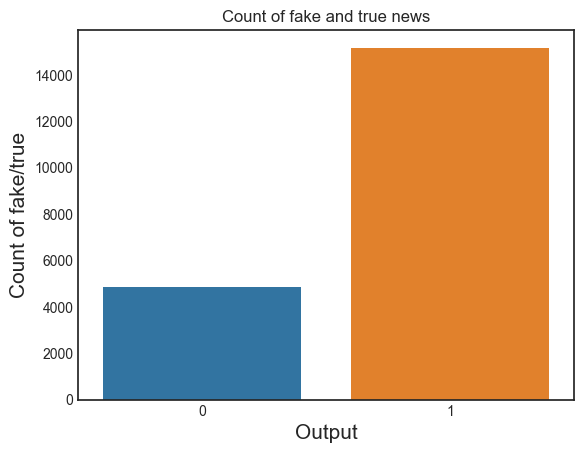

In [58]:
## Count of fake news and true news
ax=sns.countplot(x="label", data=gossipcop)
#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

In [59]:
gossipcop['label'].value_counts()

1    15167
0     4830
Name: label, dtype: int64

### Stemming

In [60]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(gossipcop)):
    news = re.sub('[^a-zA-Z]', ' ', str(gossipcop['news'][i]))
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news) 

In [61]:
gossipcop.head(3)

,news,polarity,source,label
0,donald glover,0.0,0,1
1,everything know kevin harts alleged extortion ...,-0.1,1,0
2,oscars memorable academy awards acceptance spe...,0.5,2,1


In [62]:
#save point 4 after stemming 
gossipcop.to_csv(os.path.join(data_dir, 'gossipcop_stp_fS_fe_stm.csv'), index=False)

In [63]:
gossipcop= pd.read_csv(os.path.join(data_dir,'gossipcop_stp_fS_fe_stm.csv'))
gossipcop

,news,polarity,source,label
0,donald glover,0.00,0,1
1,everything know kevin harts alleged extortion ...,-0.10,1,0
2,oscars memorable academy awards acceptance spe...,0.50,2,1
3,ariana grande arrives england manchester benef...,0.00,3,1
4,prince royce goes shirtless dancing underwear ...,0.25,4,1
...,...,...,...,...
19992,would thought kylie would successful kardashian,0.75,807,0
19993,beyonce shows flawless figure serena williams ...,1.00,34,1
19994,met gala katy perry flew kim kardashians nails la,0.00,1,1
19995,caitlyn jenner caught dinner date ex girlfrien...,0.00,185,0


In [64]:
train_dataset_adrs= os.path.join(data_dir,'train_data')
try:
    os.mkdir(train_dataset_adrs)
except  FileExistsError:
    pass

## Vectorization news column

### Bag of words

In [65]:
# bag of words
def bow(data):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer()
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'],axis= 1).values) 
    vectorized_data= hstack([news_vectorized,rest]) 
    return vectorized_data


In [66]:
gossipcop_bow= bow(gossipcop)
# from now, the name of datasets will be changed based on vectorization techniques
#save point 5, gossipcop bag of words
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_bow.npz'), gossipcop_bow)
vec_tech_list= ['gossipcop_bow.npz']

### N-gram analysis

In [67]:
# one gram 
def one_gram(data):
    # Create a CountVectorizer object with unigrams
    vectorizer = CountVectorizer(ngram_range=(1, 1))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [68]:
gossipcop_one_gram= one_gram(gossipcop)
#save point 7, gossipcop one gram
vec_tech_list.append('gossipcop_one_gram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_one_gram.npz'), gossipcop_one_gram)

In [69]:
# bigram 
def bigram(data):
    # Create a CountVectorizer object with unigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [70]:
gossipcop_bigram= bigram(gossipcop)
#save point 8, gossipcop bigram
vec_tech_list.append('gossipcop_bigram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_bigram.npz'), gossipcop_bigram)

In [71]:
# trigram 
def trigram(data):
    # Create a CountVectorizer object with trigrams
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(3, 3))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [72]:
gossipcop_trigram= trigram(gossipcop)
#save point 9, gossipcop trigram
vec_tech_list.append('gossipcop_trigram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_trigram.npz'), gossipcop_trigram)

In [73]:
# one to trigram 
def one_to_trigram(data):
    # Create a CountVectorizer object with unigrams
    vectorizer = CountVectorizer(ngram_range=(1, 3))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [74]:
gossipcop_one_to_trigram= one_to_trigram(gossipcop)
#save point 10, gossipcop one to trigram
vec_tech_list.append('gossipcop_one_to_trigram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_one_to_trigram.npz'), gossipcop_one_to_trigram)

In [75]:
# TFIDF 
def TFIDF(data):
    # Create a TfidfVectorizer object with unigrams and bigrams
    vectorizer = TfidfVectorizer( ngram_range=(1, 2))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [76]:
gossipcop_TFIDF= TFIDF(gossipcop)
#save point 11, gossipcop TF
vec_tech_list.append('gossipcop_TFIDF.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_TFIDF.npz'), gossipcop_TFIDF)

In [77]:
# Word to Vector
def W2V(data):
    # Tokenize the text data
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)
    news_vectors = [model.wv[words] for words in tokenized_news]
    #converting vectorized list to np.array
#     news_vectors_array = np.array(news_vectors)
    news_vectors_mean = np.array([np.mean(vector_list, axis=0) for vector_list in news_vectors])
    rest= data.drop(['news','label'], axis= 1).values
    combined_features = np.hstack((news_vectors_mean, rest))
    return csr_matrix(combined_features)

In [78]:
gossipcop_W2V= W2V(gossipcop)
#save point 12, gossipcop Word to vector
vec_tech_list.append('gossipcop_W2V.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_W2V.npz'), gossipcop_W2V)

### combined vectorization techniques 

In [79]:
# Combine Bag-of-Words and Word2Vec vectorization methods
def bow_w2v(data):
    # Bag-of-Words (BoW) vectorization
    bow_vectorizer = CountVectorizer()
    bow_matrix = bow_vectorizer.fit_transform(data['news'])
    
    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]
    
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)
    
    # Compute the mean of word vectors for each news article
    w2v_vectors = [np.mean(w2v_model.wv[words], axis=0) for words in tokenized_news]
    
    # Convert the list of mean vectors to a 2D array
    w2v_vectors_array = csr_matrix(w2v_vectors)
    # taking rest of selected features
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    # Combine BoW and Word2Vec vectors
    combined_vectors = hstack((bow_matrix, w2v_vectors_array, rest))
    
    return combined_vectors

In [80]:
# Call the vectorization function
gossipcop_bow_w2v = bow_w2v(gossipcop)
#save point 13, gossipcop bag of word and  Word to vector combined dataset
vec_tech_list.append('gossipcop_bow_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_bow_w2v.npz'), gossipcop_bow_w2v)


In [81]:
'''
Enhancing the result of Bag-of-Words (BoW) using Word2Vec can be done through
a technique known as "word embedding augmentation." The idea is to use the 
word vectors from Word2Vec to enhance the BoW representation of text. 
This can capture more semantic information and context compared to traditional BoW.
'''
def enhanc_bow_w2v(data):
    # Create BoW vectors using CountVectorizer
    bow_vectorizer = CountVectorizer()
    bow_matrix = bow_vectorizer.fit_transform(data['news']).toarray()

    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]

    # Load a pre-trained Word2Vec model
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)

    # Enhance BoW using Word2Vec
    enhanced_bow_matrix = []
    for doc_tokens in tokenized_news:
        enhanced_bow_vector = np.zeros(len(bow_vectorizer.get_feature_names_out()))
        for token in doc_tokens:
            if token in w2v_model.wv:
                w2v_vector = w2v_model.wv[token]
                bow_index = bow_vectorizer.vocabulary_.get(token)
                enhanced_bow_vector[bow_index] = np.mean(w2v_vector)
        enhanced_bow_matrix.append(enhanced_bow_vector)

    enhanced_bow_matrix = csr_matrix(enhanced_bow_matrix)
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    # Combine BoW and Word2Vec vectors
    combined_vectors = hstack((enhanced_bow_matrix, rest))
    # Convert the list of enhanced BoW vectors to a NumPy array
    return combined_vectors



In [82]:
gossipcop_enhanc_bow_w2v= enhanc_bow_w2v(gossipcop)
#save point 14, gossipcop bag of word and Word to vector enhanced combined dataset
vec_tech_list.append('gossipcop_enhanc_bow_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_enhanc_bow_w2v.npz'), gossipcop_enhanc_bow_w2v)

In [83]:
# Combine TFIDF and Word2Vec vectorization methods
def TFIDF_w2v(data):
    # Create a TfidfVectorizer object with unigrams and bigrams
    vectorizer = TfidfVectorizer( ngram_range=(1, 2))
    # Fit and transform the "news" column
    TFIDF_vectorized = vectorizer.fit_transform(data['news'])
    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)  
    # Compute the mean of word vectors for each news article
    w2v_vectors = [np.mean(w2v_model.wv[words], axis=0) for words in tokenized_news] 
    # Convert the list of mean vectors to a 2D array
    w2v_vectors_array = csr_matrix(w2v_vectors)
    # taking rest of selected features
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    # Combine BoW and Word2Vec vectors
    combined_vectors = hstack((TFIDF_vectorized, w2v_vectors_array, rest))
    
    return combined_vectors

In [84]:
# Call the vectorization function
gossipcop_TFIDF_w2v = TFIDF_w2v(gossipcop)
#save point 15, gossipcop TFIDF and  Word to vector combined dataset
vec_tech_list.append('gossipcop_TFIDF_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_TFIDF_w2v.npz'), gossipcop_TFIDF_w2v)

In [85]:
gossipcop_TFIDF_w2v

<19997x108831 sparse matrix of type '<class 'numpy.float64'>'
	with 2328415 stored elements in Compressed Sparse Row format>

In [86]:
'''
Enhancing the result of TFIDF using Word2Vec can be done through
a technique known as "word embedding augmentation." The idea is to use the 
word vectors from Word2Vec to enhance the BoW representation of text. 
This can capture more semantic information and context compared to traditional BoW.
'''
def enhance_TFIDF_w2v(data):
    # Create TF-IDF vectors using TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['news'])

    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]

    # Load a pre-trained Word2Vec model
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)

    # Enhance BoW using Word2Vec
    enhanced_bow_matrix = []
    for doc_tokens in tokenized_news:
        enhanced_bow_vector = np.zeros(len(tfidf_vectorizer.get_feature_names_out()))
        for token in doc_tokens:
            if token in w2v_model.wv:
                w2v_vector = w2v_model.wv[token]
                bow_index = tfidf_vectorizer.vocabulary_.get(token)
                enhanced_bow_vector[bow_index] = np.mean(w2v_vector)
        enhanced_bow_matrix.append(enhanced_bow_vector)

    enhanced_bow_matrix = csr_matrix(enhanced_bow_matrix)
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    # Combine BoW and Word2Vec vectors
    combined_vectors = hstack((enhanced_bow_matrix, rest))
    # Convert the list of enhanced BoW vectors to a NumPy array
    return combined_vectors

In [87]:
gossipcop_enhance_TFIDF_w2v= enhance_TFIDF_w2v(gossipcop)
# save point 16, gossipcop bag of word and  Word to vector enhanced combined dataset
vec_tech_list.append('gossipcop_enhance_TFIDF_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'gossipcop_enhance_TFIDF_w2v.npz'), gossipcop_enhance_TFIDF_w2v)

In [88]:
gossipcop_enhance_TFIDF_w2v.shape

(19997, 17044)

In [89]:
label= gossipcop['label']
label.shape

(19997,)

In [90]:
# saving label column in a sperate sparce matrix file
label.to_csv(os.path.join(train_dataset_adrs, 'gossipcop_label.csv'), index= False)

In [91]:
vec_tech_list

['gossipcop_bow.npz',
 'gossipcop_one_gram.npz',
 'gossipcop_bigram.npz',
 'gossipcop_trigram.npz',
 'gossipcop_one_to_trigram.npz',
 'gossipcop_TFIDF.npz',
 'gossipcop_W2V.npz',
 'gossipcop_bow_w2v.npz',
 'gossipcop_enhanc_bow_w2v.npz',
 'gossipcop_TFIDF_w2v.npz',
 'gossipcop_enhance_TFIDF_w2v.npz']